Inicialización del programa

In [192]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee

import scipy as sp
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,8  # Default image size for this interactive session

import astropy
from astropy.modeling import models, fitting

import astroML 
from astroML.stats import mean_sigma 
from astroML.time_series import search_frequencies, lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap, MultiTermFit 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

In [172]:
#Properties of Planet Candidate (Data taken from Spreadsheet)
depth = 0.15*0.01 # (In )ABSOLUTE TERMS
period = 19.306566 # (In days)
ecc = 0.0
b = 0.5

t0 = 1919.57971 # (-2454900) 
Rp = 3.47 
Mp = 31.87

#Star properties (from http://arxiv.org/pdf/1503.07866v1.pdf)
mass = 0.93
masserr = (0.05+0.06)/2.0
radius = 0.93
radiuserr = (0.05+0.06)/2.0
Teff = 5553
# From Claret (From Roberto's USPmass program)
u1 = 0.44 
u2 = 0.24
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep]

Lectura del archivo

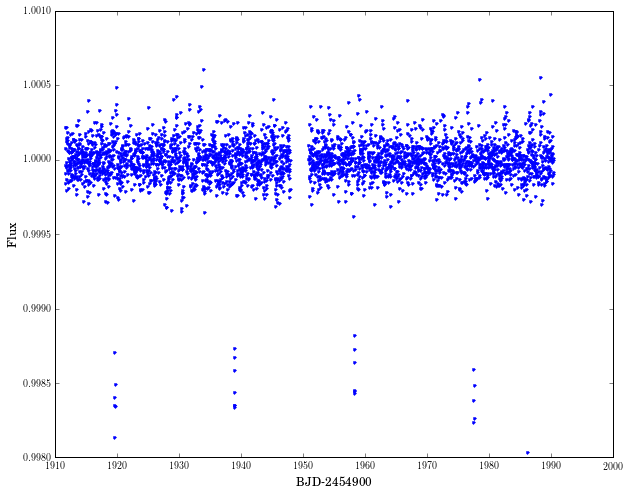

In [173]:
import glob, os
os.chdir("/Users/mariona/Desktop/summer2015")
for file in glob.glob("LCfluxesepic*.txt"):
    data = pd.read_table(file, sep='\s+', header = None, names=['time', 'flux','other'])
    timeLC = data['time']
    fluxLC = data['flux']
    errorLC = np.std(fluxLC)
    meanFlux = np.mean(fluxLC)
    goodP = fluxLC<=meanFlux+3*errorLC
    plt.figure(1)
    plt.plot(timeLC[goodP], fluxLC[goodP],'.')
    plt.xlabel('BJD-2454900', fontsize=12)
    plt.ylabel('Flux', fontsize=12)

In [174]:
minTime = min(timeLC) 
maxTime = max(timeLC)

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step
        
minepoch = -10
maxepoch = 20
numepochs = maxepoch-minepoch+1

transitLoc = np.empty(numepochs)

for x in my_range(minepoch, maxepoch, 1):
    transit = t0+x*period
    transitLoc[x-minepoch]=transit
    
goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
transits = transitLoc[goodTrans] # Stores transit times

[ 1919.57971   1938.886276  1958.192842  1977.499408]


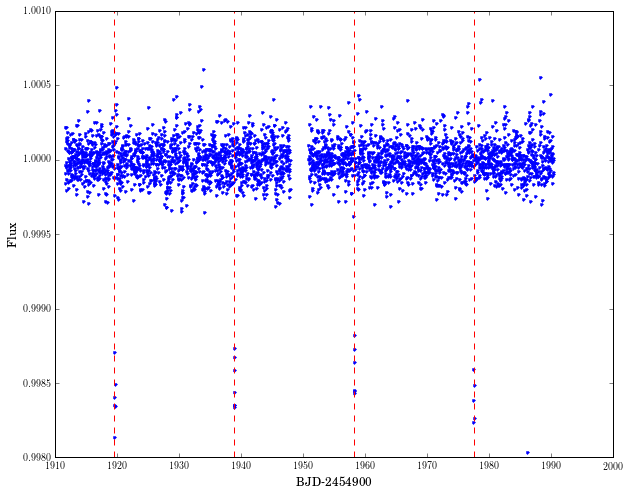

In [175]:
print transits
num_transits = len(transits)
plt.figure(2)
plt.plot(timeLC[goodP], fluxLC[goodP],'.')
plt.xlabel('BJD-2454900', fontsize=12)
plt.ylabel('Flux', fontsize=12)
for i in range(0,num_transits):
    plt.axvline(transits[i],color='r',ls='dashed')

106


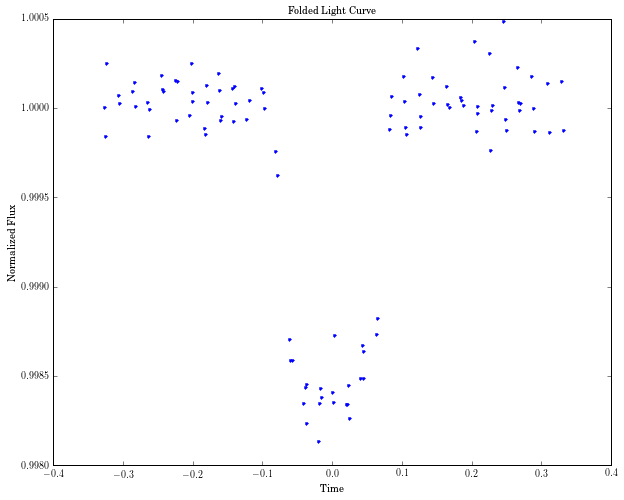

In [176]:
# Selección de puntos que están a menos de X horas del tránsito

t=timeLC[goodP]
f=fluxLC[goodP]
transit_window = 8.0 #In hours
window = transit_window/24 # In days

sumPoints=0

for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   sumPoints=np.sum(selPoints)+sumPoints

print sumPoints #Cantidad total de puntos en los 4 tránsitos en la franja que nos interesa

timeTrans = np.empty(sumPoints)
fluxTrans = np.empty(sumPoints)
flag = np.empty(sumPoints)
midTrans = np.empty(sumPoints)

sumPoints = 0
for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   numPoints = np.sum(selPoints)
   timeTrans[0+sumPoints:numPoints+sumPoints] = t[selPoints]
   fluxTrans[0+sumPoints:numPoints+sumPoints] = f[selPoints]
   flag[0+sumPoints:numPoints+sumPoints] = i
   midTrans[0+sumPoints:numPoints+sumPoints] = transits[i] 
   sumPoints = numPoints + sumPoints 

#Plot the folded light curve:
dt = timeTrans-midTrans
plt.plot(dt, fluxTrans,'.')
plt.title('Folded Light Curve')
plt.xlabel('Time')
plt.ylabel('Normalized Flux')

In [177]:
rangeTransit = 0.1

dataBool = np.abs(dt)>=rangeTransit #True: Point is outside of the transit.
print dataBool
out = (timeTrans<=rangeTransit) & (timeTrans>=rangeTransit) # Returns boolean"

[ True  True  True  True  True  True  True  True  True  True  True  True
 False False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False False False False False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False  True  True  True  True  True
  True  True  True  True  True False False False False False False  True
  True  True  True  True  True  True  True  True  True  True]


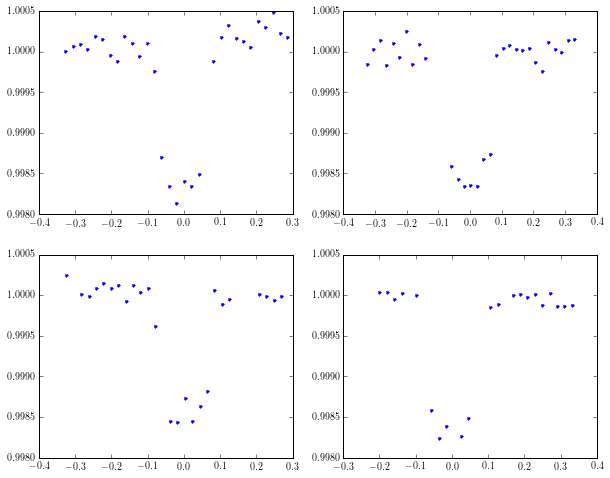

In [178]:
#Plot each transit

plt.figure(3)
for i in range(0,len(transits)):
    transitBool=(flag==i) # np.abs(dt)>=rangeTransit
    plt.subplot(2,2,i+1)
    plt.plot(dt[transitBool],fluxTrans[transitBool],'.')

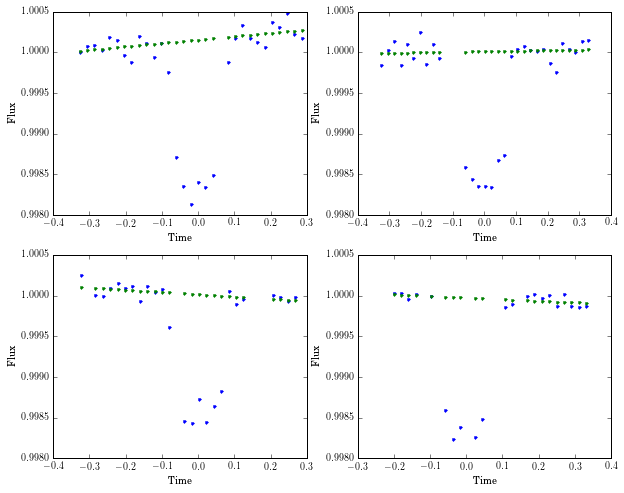

In [179]:
#Fit to the regions outside of the transit
plt.figure(4)
for i in range(0,len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    plt.subplot(2,2,i+1)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    plt.plot(dt[transitBool],fluxTrans[transitBool],'.')
    plt.plot(dt[transitBool],p(dt[transitBool]),'.')
    plt.xlabel('Time')
    plt.ylabel('Flux')

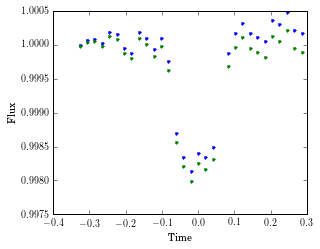

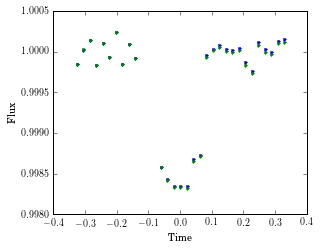

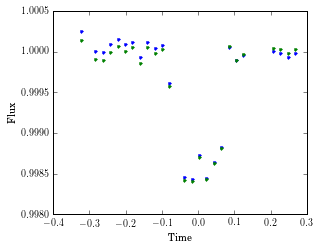

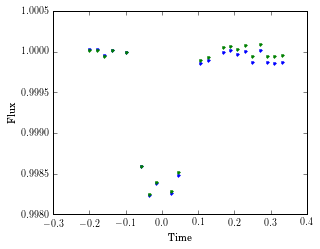

In [180]:
#Divide the light curves by the fit 
plt.figure(5)
corFlux=fluxTrans
for i in range(0,len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    plt.subplot(2,2,i+1)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    plt.plot(dt[transitBool],fluxTrans[transitBool],'.')
    plt.plot(dt[transitBool],fluxTrans[transitBool]/p(dt[transitBool]),'.')
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.show()
    corFlux[transitBool]=fluxTrans[transitBool]/p(dt[transitBool])

In [193]:
import transit
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):

    """Calculates the log of the likelihood of the transit model being the right model given the following parameters:
    theta[0] = pdepth = (Rp/Rs)^2
    theta[1] = pb = the impact parameter 
    theta[2] = pt0 = the time of transit
    theta[3] = sigma = an additional white noise term
    theta[4] = u1 + u2 = sum of LD coefficients
    theta[5] = pmass = the mass of the star (controlled via gaussian prior)
    theta[6] = pradius = the radius of the star (controlled via gaussian prior)
    theta[7] = f0 = the out of eclipse flux"""
    
    # Theta: Vector containing the variables listed above. 
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    
    #Below are the parameters entered in the previous window. 
    period, ecc, mass, masserr, radius, radiuserr, diffLD, tKep = allfixed 
    
    # Redefinition of the LD coefficients with the parameters used in this function. 
    u1 = 0.5*(sumLD+diffLD) 
    u2 = sumLD-u1
   
    #Use of the transit library. We will generate an artificial light curve with the parameters that we know 
    #and with those that we want to fit. 
    
    # First step: We use the "transit.System(transit.Central()))" module to create a planetary 'system' with a 
    #'central' bright star and a number N (>=0) of bodies in orbit. As the website notes, the default orbits of such
    # celestial objects are 100% Keplerian unless specified with subclasses. The parameters used to model the
    # 'central' star are the LD coefficients (mu1, mu2), its mass (pmass), and its radius (pradius). We have chosen
    # not to include the number of bodies in the system. 

    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass=pmass,radius=pradius))
    
    # Second step: We will use the "transit.Body" library to define the properties of our planet in the planetary system. 
    # The input parameters are the radius of the planet (r=Rp: this is calculated by taking the sqrt of
    # pdepth -- obtaining Rp/Rs -- and then multiplying by the radius of the star (pradius, which corresponds to Rs)
    # to obtain Rp), its period (given in the previous window), the time at which the transit occurs (t0 = pt0), the 
    # absolute value of the impact parameter, and the eccentricity (which we have also defined in the previous window.) 
   
   
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
    
    # Third step: Add the planet to the system s. 
    s.add_body(body)
    
    # Fourth step
    inv_sigma2 = 1.0/(errorLC**2 + sigma**2)
    
    # Fifth step: With the definitions of our planet and star, we create a theoretical curve (ftheo). 
    # The input parameters are the times where the light curve should be evaluated in days (timeLC), the time of 
    # exposure (texp = tKep), the "stopping criterion for the exposure time integration" (t01=10^-8), and the 
    # "maximum depth of the exposure time integrator" (maxdepth).
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)
    
    # Sixth Step: We subtract 1 and add the out of eclipse flux (f0) to our theoretical light curve.  
    ftheo = ftheo-1+f0
    
    # Seventh Step: Returns probability of the theoretical model to be the right model given the parameters that
    # characterize the star and the planet in our system.
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((pmass-mass)/masserr)**2
            + ((pradius-radius)/radiuserr)**2)

In [194]:
def lnprior(theta):
    pdepth, pb, pt0, sigma, sumLD, pmass, pradius, f0 = theta
    if (0.4 < sumLD < 1.0) and (0 <= pb <1.0) and (0 <= sigma):
        return 0.0
    return -np.inf

In [195]:
"""It is important that the first argument of the probability function is the position of a single walker 
(a N dimensional numpy array). The following arguments are going to be constant every time the function
is called and the values come from the args parameter of our EnsembleSampler that we’ll see soon."""

def lnprob(theta, timeLC, fluxLC, errorLC, allfixed):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)

In [196]:
# Lambda is a simple way of writing a scalar function of one or more variables. In our case, we have: 
# x(args)=-lnprob(args).

nll = lambda *args: -lnprob(*args)

# We will now minimize the function nll using the library"scipy.optimize.minimize". 
# The Input parameters are "minimize(1,2,3..)", where 1,2,3... are: 
'''
     1) fun: Our scalar function --> nll
     2) x0: Initial guess --> [1.2*depth, b (impact parameter), 0.0 (t0), 0.0 (sigma), 0.6 (sumLD), mass (mass star), 
            radius (radius star), 1.0 (f0)
     3) args: Extra arguments passed to the objective function & its derivatives --> args = (timeLC, fluxLC,
              errorLC, allfixed)
     4) Options --> options={'disp' : True}. Set to True to print convergence messages
     5) Method: Type of solver (default is None) --> method='Nelder-Mead'. The Nelder-Mead method is used
               to find the minimum or maximum of a function in a many-dimensional space. It's applied to 
               nonlinear optimization problems for which derivatives may not be known."  
 '''

result = op.minimize(nll, [1.2*depth, b, 0.0, 0.0, 0.6, mass, radius, 1.0], 
                     args=(dt, fluxTrans, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')

# Results of minimization (i.e. best guesses for depth, b, t0, sigma, sumLD, mass, radius, f0) are stored in "result"s
depth_ml, b_ml,  t0_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml  = result["x"]

# Readjust LD coefficients. 
u1_ml = 0.5*(sumLD_ml + diffLD)
u2_ml = sumLD_ml-u1_ml

Optimization terminated successfully.
         Current function value: -873.272067
         Iterations: 686
         Function evaluations: 1038


Compute the LC integrated over a Kepler long cadence exposure time with the results obtained in minimization process.

In [197]:
s = transit.System(transit.Central(mu1=u1_ml, mu2=u2_ml, mass = mass_ml, radius = radius_ml ))
body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0_ml, b=b_ml, e=ecc)
s.add_body(body)

t_theory = np.arange(-1, 1, tKep*0.01)
f_theory = s.light_curve(t_theory, texp=tKep, tol=1e-08, maxdepth=4)
f_theory = f_theory-1.0 + f0_ml

Plot of the theoretical and the observed data on the same graph

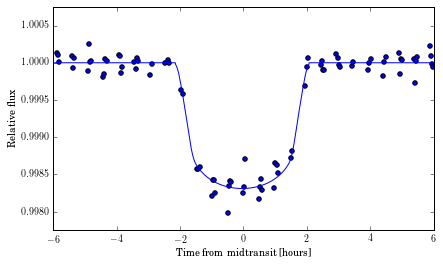

In [198]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(24.0*dt,fluxTrans)
plt.xlim([-6.0, 6.0]) 
plt.ylim([1-depth*1.5, depth*0.5+1]) 
ax.set_xlabel('Time from midtransit [hours]')
ax.set_ylabel('Relative flux')
ax.plot(24.0*t_theory, f_theory)

Print the best guesses. 

In [199]:
depth_ml, b_ml,  t0_ml, sigma_ml

(0.0015680696538514869,
 0.62469104206515302,
 -0.0015666949533948106,
 1.2217255686889373e-10)

With the best fit solution, we'll run an MCMC routine to estimate the uncertainties on the parameters

In [200]:
# From EMCEE Website: 
'''
   Recall: We want the probability density p of having a transit for specific values. The function lnprob returns the
           logarithm of such probabilty (the emcee code requires that we compute the log of p. 
           
   ndim: Nº of dimensions.
   nwalkers: Nº of walkers.
   
   Walkers: Members of the ensemble. The proposal distribution for a given walker depends on the
   positions of all the other walkers in the ensemble. The walkers quickly branch out and explore 
   the rest of the space.   
'''

ndim, nwalkers = 8, 100

# From EMCEE website:
'''
    It's important that the first argument of the probability function is the position of a single walker
    (a N dimensional np.array). The following arguments are going to be constant every time the function is 
    called and the values come from the args parameter of our "EnsembleSampler" that we’ll below. Before we go
    on, we need to guess a starting point for each of the "nwalkers". This position will be a "ndim" vector, so
    the initial guess should be an "nwalkers" by "ndim" array -- or a list of "nwalkers" arrays that each have
    "ndim" elements. It's not a very good guess but we'll just guess a random number between 0 and 1 for each
    
    np.random.randn(): Return a sample (or samples) from the “standard normal” distribution.
'''

pos = [result["x"]*(1+1e-3*np.random.randn(ndim)) for i in range(nwalkers)]

In [212]:
# From EMCEE website:

'''How to use "emcee.EnsembleSampler(1,2,3...):
        1) nwalkers: Nº of Goodman & Weare “walkers” --> nwalkers
        2) dim: Nº of dimensions in the parameter space --> ndim
        3) lnpostfn: A function that takes a vector in the parameter space as input and returns the 
                     natural logarithm of the posterior probability for that position --> lnprob
        4) a: Optional. Proposal scale parameter. (default: 2.0) --> N/A. 
        5) args=[]: Optional. A list of extra positional arguments for lnpostfn. lnpostfn will be called 
                    with the sequence lnpostfn(p, *args, **kwargs) --> args=(timeLC, fluxLC, errorLC, allfixed)
           
    What happens after each iteration? The ensembleSampler generator gives us: 
        1) pos: A list of the current positions of the walkers in the parameter space. The shape of this object 
                will be (nwalkers, dim).
        2) lnprob: The list of log posterior probabilities for the walkers at positions given by pos. The shape 
                   of this object is (nwalkers, dim).
        3) rstate: The current state of the random number generator.
        4) blobs: Optional. The metadata “blobs” associated with the current position. The value is 
                  only returned if lnpostfn returns blobs too.
'''

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,args=(timeLC, fluxLC, errorLC, allfixed))

# We do our production run with "st" steps.

st = 1000
sampler.run_mcmc(pos, st)

emcee: Exception while calling your likelihood function:
  params: [  1.94564972e-03   8.10878472e-01  -9.88856227e-04   1.88287758e-10
   4.07077954e-01   6.26219968e-01  -1.43705337e-01   9.99954091e-01]
  args: (0     1911.590471
1     1911.610903
2     1911.631336
3     1911.651768
4     1911.672200
5     1911.692632
6     1911.713064
7     1911.733497
8     1911.753929
9     1911.774361
10    1911.794793
11    1911.815225
12    1911.835658
13    1911.856090
14    1911.876522
...
3070    1990.028154
3071    1990.048586
3072    1990.069018
3073    1990.089450
3074    1990.109882
3075    1990.130314
3076    1990.150746
3077    1990.171177
3078    1990.191609
3079    1990.212041
3080    1990.232473
3081    1990.273337
3082    1990.293769
3083    1990.314201
3084    1990.334633
Name: time, Length: 3085, dtype: float64, 0     0.999842
1     1.000076
2     0.999963
3     1.000221
4     0.999909
5     0.999869
6     0.999987
7     1.000145
8     0.999797
9     0.999957
10    0.999949
11  

Traceback (most recent call last):
  File "/Users/mariona/anaconda/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-195-878f6bb57e5d>", line 9, in lnprob
    return lp + lnlike(theta, timeLC, fluxLC, errorLC, allfixed)
  File "<ipython-input-193-20734ec428a5>", line 42, in lnlike
    body = transit.Body(r=np.sqrt(pdepth)*pradius, period=period, t0=pt0, b=np.abs(pb), e=ecc)
  File "/Users/mariona/anaconda/lib/python2.7/site-packages/transit/transit.py", line 157, in __init__
    self.r = r
  File "/Users/mariona/anaconda/lib/python2.7/site-packages/transit/transit.py", line 200, in r
    raise ValueError("Invalid planet radius (must be non-negative)")
ValueError: Invalid planet radius (must be non-negative)


ValueError: Invalid planet radius (must be non-negative)

In [202]:
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))

In [210]:
import triangle
plt.figure(7)
fig = triangle.corner(samples, labels=["$Depth$", "$b$", "$t0$", "sigma", "u1+u2", "M_s", "R_s", "f0"])

AttributeError: 'module' object has no attribute 'corner'

In [213]:
samples[:, 2] = np.exp(samples[:, 2])

planetradsamp = 109.045*np.sqrt(samples[:,0])*samples[:, 6]

G = 6.6730e-11
P1 = period*24.0*3600.0
r_asamp = ((3.0*np.pi/(G*P1**2))*((samples[:,6]**3/samples[:, 5])/1408.0))**0.3333

depth_mcmc, b_mcmc,  t0_mcmc, sigma_mcmc, sumLD_mcmc, mass_mcmc, radius_mcmc, f0_mcmc = map(lambda v: 
                            (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [15.86, 50, 84.14], axis=0)))

v = np.percentile(planetradsamp, [16, 50, 84], axis=0)
planetrad_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

v = np.percentile(r_asamp, [16, 50, 84], axis=0)
r_a_mcmc =(v[1], v[2]-v[1], v[1]-v[0])

The planet radius in units of the Earth's radius is:

In [214]:
planetrad_mcmc

(nan, nan, nan)

The inverse of the scaled semi-major axis is:

In [215]:
r_a_mcmc

(0.031615402811520137, 0.0022500822407188203, 0.0022786042805664555)